# Задание 1

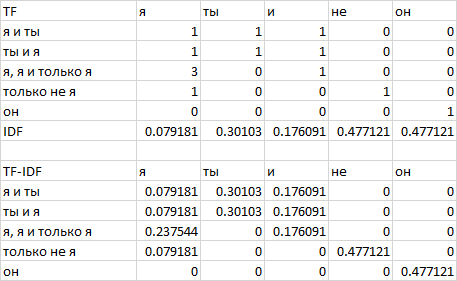

# Задание 2

In [5]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [30]:
df = pd.read_csv("labeled.csv")

In [31]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


Закодируем тексты:

In [33]:
tf_idf_matrix = TfidfVectorizer().fit_transform(df.comment)

In [46]:
tf_idf_matrix

<14412x68423 sparse matrix of type '<class 'numpy.float64'>'
	with 320935 stored elements in Compressed Sparse Row format>

## а) Посчитайте близость между 3 и 12666 текстами в датасете (labeled.csv из семинара) 

Так как в sklearn tf-idf вектора по умолчанию проходят нормализацию по L2 (делятся на кв. корень из суммы квадратов компонент), то косинусную близость между векторами можно получить, просто перемножив их:

In [40]:
tf_idf_matrix[3].toarray()[0].dot(tf_idf_matrix[12666].toarray()[0])

0.2733088629754925

## б) найдите 3 самых близких текста к тексту номер 43; выведите сами тексты и значения близостей, а не только индексы этих текстов

Аналогично пункту a) умножим вектор текста 43 на TfIdf-матрицу, чтобы получить его близость со всеми текстами:

In [57]:
similarities = tf_idf_matrix[43].dot(tf_idf_matrix.transpose())

In [58]:
similarities = similarities.toarray()[0]

Берём с -4 по -1 элементы, чтобы исключить близость текста с самим собой:

In [67]:
most_similar = similarities.argsort()[-4:-1]

In [68]:
print(df.comment[43])

Люди зажрались и охуели если по мнению этих игроков андромеда лучше Антема. Хотя че там с багаутом76 сравнивают вон... Вот оно че оказывается, игроки просто охуели, ну ок. Вот долбанные пидерасы, не хотят покупать такую отличную игру, а еще смеют ругать такой божественный геймплей. Баги, хуевый геймплей поправят, а контент, ну его запилят, через год другой, причем бесплатно! Ага. Стоит лишь потерпеть!



In [69]:
for text_id in most_similar[::-1]:
    print(df.comment[text_id], similarities[text_id])

НУ И КАКАЯ МРАЗЬ КИДАЕТ ССЫЛКИ? ОХУЕЛИ ТАМ В КРАЙ УЖЕ?
 0.16043982092396117
Че за бригада и че за махоун? Из полицейской академии? 0.11789148760536663
Герка ебет только даунов которые игрли а него. Ибо и геймплей и сюжетто кусок говна.
 0.11409080923099105


# Задание 3

In [245]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import ParameterGrid, train_test_split

import nltk

from pymorphy2.tokenizers import simple_word_tokenize
from tqdm import tqdm_notebook
from nltk import sent_tokenize

In [110]:
word_tokenize = lambda x: nltk.word_tokenize(x, language='russian')

Зададим сетки параметров для классификаторов:

In [226]:
tree_grid = list(ParameterGrid({'criterion': ('gini','entropy'),
            'class_weight': ['balanced'],
            'max_features': (None, 'sqrt', 'log2'),
            'max_depth': [i for i in range(2, 11)]+[i*10 for i in range(2, 11)]}))

In [225]:
lr_grid = list(ParameterGrid({'C': [10**i for i in range(1,6)],
                       'class_weight': ['balanced'],
                       'penalty': ['l1', 'l2'],
                       'solver': ['liblinear', 'sag', 'saga']}))

In [240]:
bayes_grid = list(ParameterGrid({'alpha': [10**(-i) for i in range(6)],
                                'fit_prior': [True, False]}))

И для векторайзеров:

In [168]:
count_grid = list(ParameterGrid({'lowercase': (True, False),
                           'tokenizer': (None, simple_word_tokenize, word_tokenize),
                            'max_df': [1.0, 0.9, 0.8],
                            'min_df':[0,0.05,0.1,0.15,0.2],
                            'stop_words': [None, nltk.corpus.stopwords.words('russian')]}))

In [169]:
tf_idf_grid = list(ParameterGrid({'lowercase': (True, False),
                           'tokenizer': (None, simple_word_tokenize, word_tokenize),
                            'max_df': [1.0, 0.9, 0.8],
                            'min_df':[0,0.05,0.1,0.15,0.2],
                            'stop_words': [None, nltk.corpus.stopwords.words('russian')],
                            'norm': ('l1','l2'),
                            'smooth_idf': (True, False)}))

In [170]:
X_train, X_test, y_train, y_test = train_test_split(df.comment, df.toxic)

Зачем подбирать параметры вручную, когда можно применить GridSearch?

In [233]:
def my_grid_search(X_train, X_test, y_train, y_test, vec_class, clf_class, vec_grid, clf_grid):
    best_vec, best_vec_params, best_clf, best_clf_params = None, None, None, None
    pbar = tqdm_notebook(total=len(vec_grid)*len(clf_grid), leave=True)
    i = 0
    best_f1 = 0
    for vec_params in vec_grid:
        vec = vec_class(**vec_params).fit(X_train)
        X_train_vec = vec.transform(X_train)
        X_test_vec = vec.transform(X_test)
        for clf_params in clf_grid:
            i += 1
            clf = clf_class(**clf_params).fit(X_train_vec, y_train)
            pred = clf.predict(X_test_vec)
            f1 = f1_score(y_test, pred)
            if i% 20 == 0:
                pbar.update(20)
            if f1 > best_f1:
                pbar.set_postfix({'Best f1_score': f1})
                best_f1 = f1
            if f1 > 0.75:
                best_vec = vec
                best_vec_params = vec_params
                best_clf = clf
                best_clf_params = clf_params
                pbar.close()
                break
        if best_vec:
            print(f"Test F1-score: {f1}")
            break
    return best_vec, best_clf, best_vec_params, best_clf_params

In [229]:
best_tfidf, best_lr, best_tfidf_params, best_lr_params = my_grid_search(X_train, X_test, y_train, y_test,
                                                                       TfidfVectorizer, LogisticRegression,
                                                                       tf_idf_grid, lr_grid)

Test F1-score: 0.7612061939690302


Посмотри на параметры классификатора/векторайзера:

In [279]:
print(best_lr_params)
print(best_tfidf_params)

{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
{'lowercase': True, 'max_df': 1.0, 'min_df': 0, 'norm': 'l1', 'smooth_idf': True, 'stop_words': None, 'tokenizer': None}


Проверим, что всё и правда хорошо:

In [230]:
X_test_vec = best_tfidf.transform(X_test)

In [231]:
print(classification_report(y_test, best_lr.predict(X_test_vec)))

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.88      2309
         1.0       0.81      0.72      0.76      1294

    accuracy                           0.84      3603
   macro avg       0.83      0.81      0.82      3603
weighted avg       0.84      0.84      0.84      3603



In [241]:
best_count, best_bayes, best_count_params, best_bayes_params = my_grid_search(X_train, X_test,
                                                                           y_train, y_test,
                                                                           CountVectorizer, MultinomialNB,
                                                                           count_grid, bayes_grid)

Test F1-score: 0.776429809358752


Посмотри на параметры классификатора/векторайзера:

In [280]:
print(best_bayes_params)
print(best_count_params)

{'alpha': 1, 'fit_prior': False}
{'lowercase': True, 'max_df': 1.0, 'min_df': 0, 'stop_words': None, 'tokenizer': None}


Проверим, что всё и правда хорошо:

In [242]:
X_test_vec = best_count.transform(X_test)
print(classification_report(y_test, best_bayes.predict(X_test_vec)))

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.89      2309
         1.0       0.88      0.69      0.78      1294

    accuracy                           0.86      3603
   macro avg       0.86      0.82      0.84      3603
weighted avg       0.86      0.86      0.85      3603



In [247]:
with open('2ch_corpus.txt','r',encoding='utf-8') as inp:
    dvach = inp.read()

dvach = sent_tokenize(dvach, language='russian')

In [268]:
def pipe(sents, clf, vectorizer):
    X = vectorizer.transform(sents)
    y = clf.predict_proba(X)
    return y

In [274]:
def top_k_preds(sents, clf, vectorizer, k=10):
    y = pipe(sents, clf, vectorizer).transpose()[1]
    top = []
    for index in y.argsort()[-1:-k-1:-1]:
        top.append((sents[index], y[index]))
    return top

In [270]:
top_toxic_lr_tfidf = top_k_preds(dvach, best_lr, best_tfidf)
top_toxic_bayes_count = top_k_preds(dvach, best_bayes, best_count)

In [271]:
for sent in top_toxic_lr_tfidf:
    print(sent)

('Пиздец.', 1.0)
('Узколобое быдло.', 1.0)
('Ты отвратительно питаешься.', 1.0)
('Ты тормоз.', 1.0)
('Пиздец.', 1.0)
('Сука.', 1.0)
('Пиздец.', 1.0)
('ПИЗДЕЦ БЛЯЯЯЯТЬ!!', 1.0)
('Ты рукожоп.', 1.0)
('Ну и дебил.', 1.0)


In [272]:
for sent in top_toxic_bayes_count:
    print(sent)

('Прошлые треды: - Тред №1 - №80 — Тред №81 — Тред №82 — Тред №83 — Тред №84 — Тред №85 — Тред №86 — Тред №87 — Тред №88 — Тред №89 — Тред №90 — Тред №91 — Тред №92 — Тред №93 — Тред №94 — Тред №95 — Тред №96 — Тред №97 — Тред №98 — Тред №99 — Тред №100 — Тред №101 — Тред №102 — Тред №103 — Тред №104 — Тред №105 — Тред №106 — Тред №107 — Тред №108 — Тред №109 — Тред №110 — Тред №111 — Тред №112 — Тред №113 — Тред №114 — Тред №115 — Тред №116 — Тред №117 — Тред №118 — Тред №119 — Тред №120 — Тред №121УСТРОИМ ШЛЮХАМ И ПЕДОФИЛАМ ПРАЗДНИК!', 1.0)
('Прошлые треды: - Тред №1 - №80 — Тред №81 — Тред №82 — Тред №83 — Тред №84 — Тред №85 — Тред №86 — Тред №87 — Тред №88 — Тред №89 — Тред №90 — Тред №91 — Тред №92 — Тред №93 — Тред №94 — Тред №95 — Тред №96 - Тред №97 - Тред №98 — Тред №99 — Тред №100 — Тред №101 — Тред №102 — Тред №103 — Тред №104 — Тред №105 — Тред №106 — Тред №107УСТРОИМ ШЛЮХАМ ПРАЗДНИК!', 1.0)
('МАЗДА ПЛАЧЕТ А ВЕРСУС ХЕР ТЕ)))\n  РЮЗКЕ ДВОРЫОБОССАНЫЕ ХРУЩОБЫПАНЕЛЬКИ В ХИПСТО

('Ты дебил тупой блять читай пуе хуесосина прежде чем лезть, на профиле запросто может появиться напряжение из-за поврежденой изоляции кабеля, сука блять как же я тебя не навижу тупой урод и всех вас таких которые нихуя не знают но лезут блять и свое мнение выпячивают как будто и блять они николы теслы ебаные\n >На бтонном потолке запрещено гофру использоватьоткуда ты такой вылез умник блять.', 1.0)
('htmПрошлые треды: — Тред №1 — Тред №2 — Тред №3 — Тред №4 — Тред №5 — Тред №6 — Тред №7 — Тред №8 — Тред №9 — Тред №10 — Тред №11 — Тред №12 — Тред №13 — Тред №14 — Тред №15 — Тред №16 — Тред №17 — Тред №18 — Тред №19 — Тред №20 — Тред №21 — Тред №22 — Тред №23 — Тред №24 — Тред №25 — Тред №26 — Тред №27 — Тред №28 — Тред №29 — Тред №30 — Тред №31 — Тред №32 — Тред №33 — Тред №34 — Тред №35 — Тред №36 — Тред №37 — Тред №38 — Тред №39 — Тред №40 — Тред №41 — Тред №43 — Тред №44 — Тред №45 — Тред №46 — Тред №47\n Вы когда остановитесь?', 1.0)


<b>Вывод</b>: Среди 10 самых токсичных предложений из корпуса dvach, предсказанных Пайплайном A (логистическая регрессия + Tf-Idf Vectorizer) и Пайплайном B (Multinomial Naive Bayes + Count Vectorizer) ни одно предложение не совпало. Пайплайн A присваивал наибольшую вероятность коротким предложениям, полностью состоящим (за исключением служебных слов, нейтрализованных за счёт idf) из оскорбительных и нецензурных слов, а Пайплайн B - длиннымм аномальным текстам (в т.ч. получившимся при парсинге разметки сайта), содержащим оскорбительную/нецензурную лексику. Все предложения, распознанных Пайплайнами A и B как токсиные таковыми и являются, однако предложения, выделенные Пайплайном B содержат много нетоксичной информации, выделенной из разметки страниц сайта.